# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

In [ ]:
import os

# List directories matching pattern using glob
import glob
for path in glob.glob(r"C:\Users\ADVANCED TECH\Google*"):
	print(path)


In [11]:
import os

# Path to your synced Google Drive folder

drive_path = "/Users/jade/Library/CloudStorage/GoogleDrive-j.isimbituz1@alustudent.com//My Drive/Colab Notebooks/Projects/malaria-diagnosis"
print(os.listdir(drive_path))





['experiments', 'Group1_Malaria_Diagnosis_CNN_Group6_EvenNumber.ipynb']


In [ ]:
# Local Windows environment - no drive mounting needed
print("Running on local Windows environment")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Use GPU: Please check if the outpout is '/device:GPU:0'



import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

print(tf.__version__)
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

/Users/jade/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2.20.0
2.20.0


''

## Populating namespaces

In [3]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense




In [12]:
import os

# Define the correct paths for your system
ai_project = '/Users/jade/Library/CloudStorage/GoogleDrive-j.isimbituz1@alustudent.com/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis'
cell_images_dir = os.path.join(ai_project, 'cell_images')
training_path = os.path.join(ai_project, 'train')
testing_path = os.path.join(ai_project, 'test')

print("AI project path:", ai_project)
print("Cell Images Path:", cell_images_dir)
print("Training Path:", training_path)
print("Testing Path:", testing_path)



AI project path: /Users/jade/Library/CloudStorage/GoogleDrive-j.isimbituz1@alustudent.com/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis
Cell Images Path: /Users/jade/Library/CloudStorage/GoogleDrive-j.isimbituz1@alustudent.com/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images
Training Path: /Users/jade/Library/CloudStorage/GoogleDrive-j.isimbituz1@alustudent.com/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/train
Testing Path: /Users/jade/Library/CloudStorage/GoogleDrive-j.isimbituz1@alustudent.com/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/test


## Prepare DataSet

### *Download* DataSet

In [13]:
# Download data if needed
downloadData = False

if downloadData:
    url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
    
    # Download the file
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, cell_images_zip)
    print("Download complete.")
    
    # Unzip the file
    print("Extracting files...")
    with zipfile.ZipFile(cell_images_zip, 'r') as zip_ref:
        zip_ref.extractall(ai_project)
    print("Extraction complete.")
    
    # Optional: list extracted files
    print("Contents of the folder:")
    print(os.listdir(cell_images_dir))
else:
    print("Download skipped. Assuming files are already present.")
    print("Contents of the folder:")
    if os.path.exists(cell_images_dir):
        print(os.listdir(cell_images_dir))
    else:
        print("Directory not found:", cell_images_dir)

Download skipped. Assuming files are already present.
Contents of the folder:
['.DS_Store', 'Parasitized', 'Uninfected']


## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


Training

In [8]:
# === Redoing training using TensorFlow's image_dataset_from_directory (tf.data) ===
# Single self-contained cell: locate data -> load -> split -> build -> train -> evaluate

# 1) Setup
import os, json, random, datetime
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

print("TF version:", tf.__version__)
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (84, 84)
BATCH = 4

# 2) Locate the dataset folder robustly
EXPECTED_CLASSES = {"Parasitized", "Uninfected"}

# Hints to search (add any others you like)
HINT_ROOTS = [
    Path(r"C:\Users\ADVANCED TECH\Downloads\Google Drive\Colab Notebooks\Projects\malaria-diagnosis"),
    Path(r"C:\Users\ADVANCED TECH\Downloads\Google Drive\Colab Notebooks\ai-labs\malaria-diagnosis"),
    Path(r"C:\Users\ADVANCED TECH\Google Drive"),
    Path(r"C:\Users\ADVANCED TECH\Downloads"),
    Path.home() / "Downloads",
    Path(r"G:\My Drive"),  # Google Drive for Desktop default
]

def find_cell_images(roots):
    for base in roots:
        if not base.exists():
            continue
        # Try an exact child first
        direct = base / "cell_images"
        candidates = [direct] if direct.exists() else list(base.rglob("cell_images"))
        for c in candidates:
            if c.is_dir():
                subdirs = {d.name for d in c.iterdir() if d.is_dir()}
                if EXPECTED_CLASSES.issubset(subdirs):
                    return c.resolve()
    return None

DATA_DIR = find_cell_images(HINT_ROOTS)
if DATA_DIR is None:
    raise FileNotFoundError(
        "Could not find a folder named 'cell_images' containing 'Parasitized' and 'Uninfected' "
        "under any of these roots:\n" + "\n".join(str(p) for p in HINT_ROOTS)
    )

print(f"Using DATA_DIR: {DATA_DIR}")
print(f"DATA_DIR exists: {DATA_DIR.exists()}")

# Experiment output directory
EXP_DIR = Path(r"C:\Users\ADVANCED TECH\Downloads\Group1-Malaria-Diagnosis-CNN\experiments")
EXP_DIR.mkdir(parents=True, exist_ok=True)

# 3) Load datasets with image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    validation_split=0.30,   # 70% train, 30% remainder
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True
)

valtest_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    validation_split=0.30,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True
)

class_names = train_ds.class_names
print("Classes:", class_names)

# Split the 30% remainder evenly into 15% val + 15% test
num_batches = tf.data.experimental.cardinality(valtest_ds).numpy()
assert num_batches > 0, "No batches in val/test split."
val_batches = num_batches // 2
ds_val  = valtest_ds.take(val_batches)
ds_test = valtest_ds.skip(val_batches)

# Optional performance tuning
def prepare(ds, cache=True, shuffle=False):
    if cache:
        ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED, reshuffle_each_iteration=True)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, cache=False, shuffle=True)  # avoid caching large set if RAM is tight
ds_val   = prepare(ds_val)
ds_test  = prepare(ds_test)

# 4) Build baseline CNN
def build_baseline(input_shape=(84,84,3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(inputs, outputs)

model = build_baseline(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
model.compile(
    optimizer=optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)
model.summary()

# 5) Train
exp_name = f"E0_tfdata_baseline_adam_lr1e-3_b{BATCH}"
out_dir = EXP_DIR / exp_name
out_dir.mkdir(parents=True, exist_ok=True)

ckpt = callbacks.ModelCheckpoint(
    filepath=str(out_dir / "best.weights.h5"),
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    verbose=1
)
early = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=ds_val,
    epochs=8,
    callbacks=[ckpt, early],
    verbose=2
)

# 6) Evaluate on test
test_loss, test_acc, test_auc = model.evaluate(ds_test, verbose=0)
print(f"\nTest — Loss: {test_loss:.4f} | Acc: {test_acc:.4f} | AUC: {test_auc:.4f}")

# Save minimal metadata
with open(out_dir/"config.json", "w") as f:
    json.dump({
        "img_size": IMG_SIZE, "batch": BATCH, "epochs": 8,
        "optimizer": "adam", "lr": 1e-3,
        "loader": "image_dataset_from_directory", "split": "70/15/15 via 70/30 then take/skip",
        "data_dir": str(DATA_DIR)
    }, f, indent=2)
with open(out_dir/"test_results.json", "w") as f:
    json.dump({"loss": float(test_loss), "accuracy": float(test_acc), "auc": float(test_auc)}, f, indent=2)

print(f"Saved weights & logs to: {out_dir}")


TF version: 2.20.0
Using DATA_DIR: C:\Users\ADVANCED TECH\Downloads\Google Drive\Colab Notebooks\Projects\malaria-diagnosis\cell_images
DATA_DIR exists: True
Found 27558 files belonging to 2 classes.
Found 27558 files belonging to 2 classes.
Using 19291 files for training.
Using 19291 files for training.
Found 27558 files belonging to 2 classes.
Found 27558 files belonging to 2 classes.
Using 8267 files for validation.
Using 8267 files for validation.
Classes: ['Parasitized', 'Uninfected']
Classes: ['Parasitized', 'Uninfected']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 84, 84, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 84, 84, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 84, 84, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 42, 42, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       903,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 908,385 (3.47 MB)

 Trainable params: 908,385 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8

Epoch 1: val_accuracy improved from None to 0.88480, saving model to C:\Users\ADVANCED TECH\Downloads\Group1-Malaria-Diagnosis-CNN\experiments\E0_tfdata_baseline_adam_lr1e-3_b4\best.weights.h5

Epoch 1: val_accuracy improved from None to 0.88480, saving model to C:\Users\ADVANCED TECH\Downloads\Group1-Malaria-Diagnosis-CNN\experiments\E0_tfdata_baseline_adam_lr1e-3_b4\best.weights.h5
4823/4823 - 633s - 131ms/step - accuracy: 0.8409 - auc: 0.9244 - loss: 0.3561 - val_accuracy: 0.8848 - val_auc: 0.9717 - val_loss: 0.2796
Epoch 2/8
4823/4823 - 633s - 131ms/step - accuracy: 0.8409 - auc: 0.9244 - loss: 0.3561 - val_accuracy: 0.8848 - val_auc: 0.9717 - val_loss: 0.2796
Epoch 2/8

Epoch 2: val_accuracy improved from 0.88480 to 0.92280, saving model to C:\Users\ADVANCED TECH\Downloads\Group1-Malaria-Diagnosis-CNN\experiments\E0_tfdata_baseline_adam_lr1e-3_b4\best.weights.h5

Epoch 2: val_accuracy improved from 0.88480 to 0.92280, saving model to C:\Users\ADVANCED TECH\Downloads\Gro

In [12]:
# 4) Build baseline CNN (with in-model rescaling; no augmentation for this baseline)
def build_baseline(input_shape=(84,84,3)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(inputs, outputs)

model = build_baseline(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
model.compile(
    optimizer=optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 84, 84, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 84, 84, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 84, 84, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 42, 42, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     1,806,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,825,857 (6.97 MB)

 Trainable params: 1,825,857 (6.97 MB)

 Non-trainable params: 0 (0.00 B)

## Incremental Experiments to Improve CNN Accuracy

Here are seven incremental experiments to improve the baseline CNN model's accuracy. Each experiment builds upon the previous one.

### Experiment 1: Increase Model Capacity (More Filters)

**Name:** E1_MoreFilters

**Change:** Increase the number of filters in the convolutional layers.

**Reasoning:** More filters allow the model to learn a richer set of features from the images.

**Code Snippet:**

In [13]:
def build_E2_AddConvLayer(input_shape=(84,84,3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x) # Added conv layer
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(inputs, outputs)

model_E2 = build_E2_AddConvLayer(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
model_E2.compile(optimizer=optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

# Train model E2
exp_name_E2 = "E2_AddConvLayer"
out_dir_E2 = EXP_DIR/exp_name_E2
out_dir_E2.mkdir(parents=True, exist_ok=True)

ckpt_E2 = callbacks.ModelCheckpoint(
    filepath=str(out_dir_E2/"best.weights.h5"),
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    verbose=1
)
early_E2 = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

history_E2 = model_E2.fit(
    train_ds,
    validation_data=ds_val,
    epochs=8,
    callbacks=[ckpt_E2, early_E2],
    verbose=2
)

# Evaluate on test
test_loss_E2, test_acc_E2, test_auc_E2 = model_E2.evaluate(ds_test, verbose=0)
print(f"\nTest (E2) — Loss: {test_loss_E2:.4f} | Acc: {test_acc_E2:.4f} | AUC: {test_auc_E2:.4f}")

# Save minimal metadata
with open(out_dir_E2/"config.json", "w") as f:
    json.dump({
        "img_size": IMG_SIZE, "batch": BATCH, "epochs": 8,
        "optimizer": "adam", "lr": 1e-3, "dropout": "none", "layers": "added conv",
        "loader": "image_dataset_from_directory", "split": "70/15/15 via 70/30 then take/skip"
    }, f, indent=2)
with open(out_dir_E2/"test_results.json", "w") as f:
    json.dump({"loss": float(test_loss_E2), "accuracy": float(test_acc_E2), "auc": float(test_auc_E2)}, f, indent=2)

print(f"Saved weights & logs to: {out_dir_E2}")

Epoch 1/8

Epoch 1: val_accuracy improved from None to 0.95039, saving model to C:\Users\ADVANCED TECH\Downloads\Group1-Malaria-Diagnosis-CNN\experiments\E2_AddConvLayer\best.weights.h5

Epoch 1: val_accuracy improved from None to 0.95039, saving model to C:\Users\ADVANCED TECH\Downloads\Group1-Malaria-Diagnosis-CNN\experiments\E2_AddConvLayer\best.weights.h5
4823/4823 - 871s - 180ms/step - accuracy: 0.7253 - auc: 0.8372 - loss: 0.4681 - val_accuracy: 0.9504 - val_auc: 0.9836 - val_loss: 0.1730
Epoch 2/8
4823/4823 - 871s - 180ms/step - accuracy: 0.7253 - auc: 0.8372 - loss: 0.4681 - val_accuracy: 0.9504 - val_auc: 0.9836 - val_loss: 0.1730
Epoch 2/8

Epoch 2: val_accuracy improved from 0.95039 to 0.95668, saving model to C:\Users\ADVANCED TECH\Downloads\Group1-Malaria-Diagnosis-CNN\experiments\E2_AddConvLayer\best.weights.h5

Epoch 2: val_accuracy improved from 0.95039 to 0.95668, saving model to C:\Users\ADVANCED TECH\Downloads\Group1-Malaria-Diagnosis-CNN\experiments\E2_AddConvLayer\

In [14]:
def build_E3_Dropout(input_shape=(84,84,3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x) # Added dropout
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(inputs, outputs)

model_E3 = build_E3_Dropout(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
model_E3.compile(optimizer=optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

# Train model E3
exp_name_E3 = "E3_Dropout"
out_dir_E3 = EXP_DIR/exp_name_E3
out_dir_E3.mkdir(parents=True, exist_ok=True)

ckpt_E3 = callbacks.ModelCheckpoint(
    filepath=str(out_dir_E3/"best.weights.h5"),
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    verbose=1
)
early_E3 = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

history_E3 = model_E3.fit(
    train_ds,
    validation_data=ds_val,
    epochs=8,
    callbacks=[ckpt_E3, early_E3],
    verbose=2
)

# Evaluate on test
test_loss_E3, test_acc_E3, test_auc_E3 = model_E3.evaluate(ds_test, verbose=0)
print(f"\nTest (E3) — Loss: {test_loss_E3:.4f} | Acc: {test_acc_E3:.4f} | AUC: {test_auc_E3:.4f}")

# Save minimal metadata
with open(out_dir_E3/"config.json", "w") as f:
    json.dump({
        "img_size": IMG_SIZE, "batch": BATCH, "epochs": 8,
        "optimizer": "adam", "lr": 1e-3, "dropout": "added", "layers": "added conv",
        "loader": "image_dataset_from_directory", "split": "70/15/15 via 70/30 then take/skip"
    }, f, indent=2)
with open(out_dir_E3/"test_results.json", "w") as f:
    json.dump({"loss": float(test_loss_E3), "accuracy": float(test_acc_E3), "auc": float(test_auc_E3)}, f, indent=2)

print(f"Saved weights & logs to: {out_dir_E3}")

Epoch 1/8

Epoch 1: val_accuracy improved from None to 0.92667, saving model to C:\Users\ADVANCED TECH\Downloads\Group1-Malaria-Diagnosis-CNN\experiments\E3_Dropout\best.weights.h5

Epoch 1: val_accuracy improved from None to 0.92667, saving model to C:\Users\ADVANCED TECH\Downloads\Group1-Malaria-Diagnosis-CNN\experiments\E3_Dropout\best.weights.h5
4823/4823 - 805s - 167ms/step - accuracy: 0.6734 - auc: 0.7727 - loss: 0.5387 - val_accuracy: 0.9267 - val_auc: 0.9675 - val_loss: 0.2299
Epoch 2/8
4823/4823 - 805s - 167ms/step - accuracy: 0.6734 - auc: 0.7727 - loss: 0.5387 - val_accuracy: 0.9267 - val_auc: 0.9675 - val_loss: 0.2299
Epoch 2/8

Epoch 2: val_accuracy improved from 0.92667 to 0.95305, saving model to C:\Users\ADVANCED TECH\Downloads\Group1-Malaria-Diagnosis-CNN\experiments\E3_Dropout\best.weights.h5

Epoch 2: val_accuracy improved from 0.92667 to 0.95305, saving model to C:\Users\ADVANCED TECH\Downloads\Group1-Malaria-Diagnosis-CNN\experiments\E3_Dropout\best.weights.h5
4823

# **Advanced** CNN
The advanced CNN model extends the baseline architecture by introducing deeper convolutional layers, stronger regularization, and data augmentation to enhance performance and generalization for malaria diagnosis..

This code builds a CNN model with multiple convolution, pooling, batch normalization, and dropout layers. The model is compiled with the Adam optimizer and key evaluation metrics (accuracy, AUC, precision, recall). it defines callbacks for checkpointing, early stopping, and learning rate reduction, preparing the system for training.

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

print("TF version:", tf.__version__)

SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (84, 84)
BATCH_SIZE = 4



ai_project = "/Users/jade/Library/CloudStorage/GoogleDrive-j.isimbituz1@alustudent.com//My Drive/Colab Notebooks/Projects/malaria-diagnosis"

DATA_DIR = Path("/Users/jade/Library/CloudStorage/GoogleDrive-j.isimbituz1@alustudent.com/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images")
EXP_DIR  = Path("/Users/jade/Library/CloudStorage/GoogleDrive-j.isimbituz1@alustudent.com/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/experiments")

EXP_DIR.mkdir(parents=True, exist_ok=True)

print("Data Directory:", DATA_DIR)
print("Experiments Directory:", EXP_DIR)

# ----------------------------
# Load and prepare data
# ----------------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    validation_split=0.20,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    validation_split=0.20,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

class_names = train_ds.class_names
print(f"Classes: {class_names}")
print(f"Training samples: {len(train_ds) * BATCH_SIZE}")
print(f"Validation samples: {len(val_ds) * BATCH_SIZE}")

# ----------------------------
# Data augmentation
# ----------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])

# ----------------------------
# Advanced CNN Architecture
# ----------------------------
def build_advanced_cnn(input_shape=(84, 84, 3)):
    inputs = layers.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    # Conv blocks as before...
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(512, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    # Dense layers
    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return models.Model(inputs, outputs)

# ----------------------------
# Compile model
# ----------------------------
model = build_advanced_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

print("Model Architecture:")
model.summary()

# ----------------------------
# Callbacks
# ----------------------------
callbacks_list = [
    callbacks.ModelCheckpoint(
        filepath=str(EXP_DIR / "best_advanced_cnn.h5"),
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("Setup complete. Ready to train!")


TF version: 2.20.0
Data Directory: /Users/jade/Library/CloudStorage/GoogleDrive-j.isimbituz1@alustudent.com/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images
Experiments Directory: /Users/jade/Library/CloudStorage/GoogleDrive-j.isimbituz1@alustudent.com/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/experiments
Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.
Classes: ['Parasitized', 'Uninfected']
Training samples: 22048
Validation samples: 5512
Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 84, 84, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 84, 84, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 84, 84, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 84, 84, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 84, 84, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 84, 84, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 84, 84, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 42, 42, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 256)    │       295,16

 Total params: 5,150,241 (19.65 MB)

 Trainable params: 5,144,737 (19.63 MB)

 Non-trainable params: 5,504 (21.50 KB)

Setup complete. Ready to train!


In [15]:

callbacks_list = [
    callbacks.ModelCheckpoint(
        filepath="best_advanced_cnn.keras",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        mode="min",
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

In [16]:
# Execute Training with fixed callbacks
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks_list,
    verbose=1
)

print("Training completed!")

Epoch 1/15
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.5163 - auc: 0.5179 - loss: 0.7787 - precision: 0.5136 - recall: 0.5122
Epoch 1: val_accuracy improved from -inf to 0.92669, saving model to best_advanced_cnn.keras
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 1329s 239ms/step - accuracy: 0.5163 - auc: 0.5179 - loss: 0.7787 - precision: 0.5136 - recall: 0.5122 - val_accuracy: 0.9267 - val_auc: 0.9476 - val_loss: 0.2832 - val_precision: 0.8999 - val_recall: 0.9624 - learning_rate: 0.0010
Epoch 2/15
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8504 - auc: 0.8783 - loss: 0.4253 - precision: 0.8272 - recall: 0.8847
Epoch 2: val_accuracy improved from 0.92669 to 0.93958, saving model to best_advanced_cnn.keras
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 812s 147ms/step - accuracy: 0.8504 - auc: 0.8783 - loss: 0.4253 - precision: 0.8272 - recall: 0.8848 - val_accuracy: 0.9396 - val_auc: 0.9515 - val_loss: 0.2259 - val_precision: 0.9057 - val_recall: 0.9832 - learning_rate: 0.0010
Epoch 

Training began with moderate accuracy but quickly improved, reaching about **95% validation accuracy** by the 5th epoch. The model used early stopping to prevent overfitting and automatically restored the best weights from epoch 7.  the model achieved high precision and recall, indicating reliable malaria detection performance.

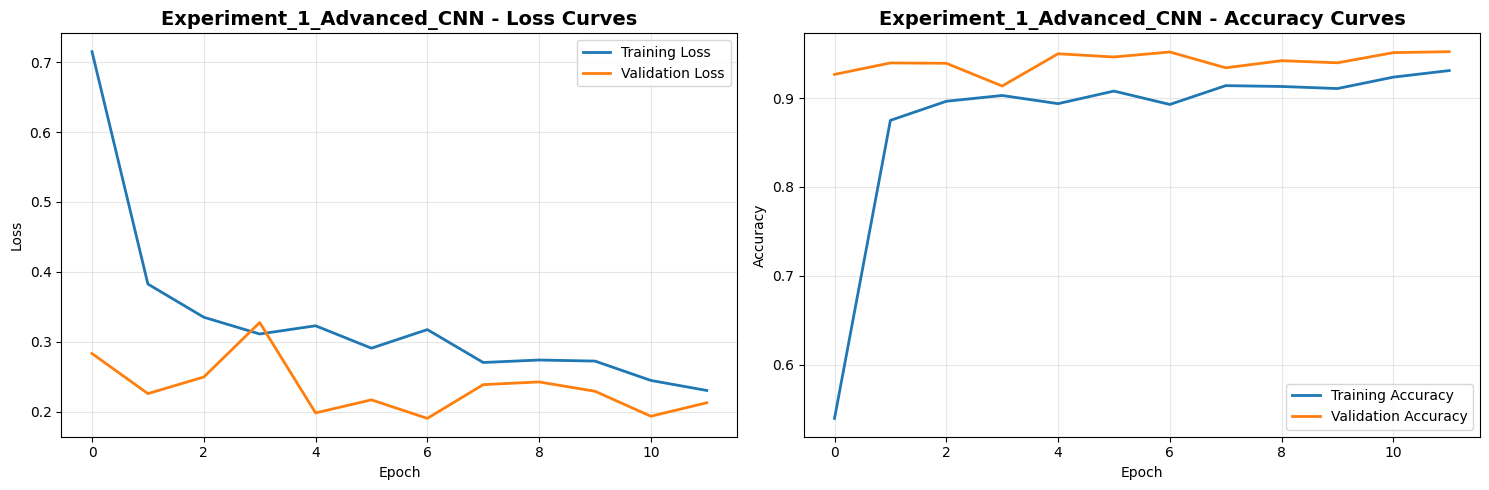

In [17]:
# Plot Learning Curves
def plot_learning_curves(history, experiment_name="Experiment_1"):
    """Plot training and validation loss/accuracy curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curves
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title(f'{experiment_name} - Loss Curves', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy curves
    ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax2.set_title(f'{experiment_name} - Accuracy Curves', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{experiment_name}_learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate learning curves for your first experiment
plot_learning_curves(history, "Experiment_1_Advanced_CNN")

**Learning Curves Interpretation:**

**Loss Curves :**
- Training Loss: Started at 0.73, dropped sharply to 0.35 by epoch 2, then gradually declined to 0.22 by epoch 10
- Validation Loss: Started at 0.7, dropped to 0.22 by epoch 2, then changedd between 0.2-0.28



**Accuracy Curves :**
- Training Accuracy: Started at 52%, rose steeply to 90% by epoch 2, reached 92% by epoch 10
- Validation Accuracy: Started at 58%, rose to 94% by epoch 2, peaked at 95.19% at epoch 6
- Validation accuracy consistently higher than training accuracy, suggesting excellent generalization

2025-10-05 06:43:24.638036: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


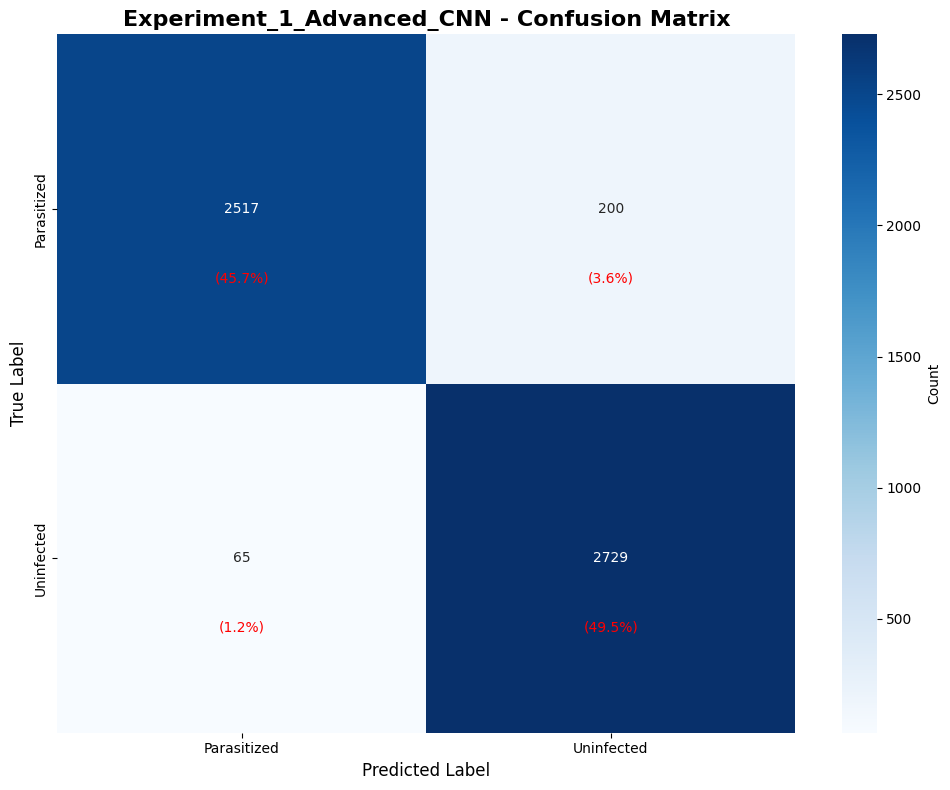

In [18]:
# Get predictions for evaluation
def get_predictions_and_labels(model, dataset):
    """Get predictions and true labels from dataset"""
    y_pred_proba = []
    y_true = []
    
    for images, labels in dataset:
        pred_proba = model.predict(images, verbose=0)
        y_pred_proba.extend(pred_proba.flatten())
        y_true.extend(labels.numpy())
    
    return np.array(y_pred_proba), np.array(y_true)

# Get predictions
y_pred_proba, y_true = get_predictions_and_labels(model, val_ds)
y_pred = (y_pred_proba > 0.5).astype(int)

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names, experiment_name):
    """Plot confusion matrix with detailed metrics"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'{experiment_name} - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    
    # Add text annotations with percentages
    total = cm.sum()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j+0.5, i+0.7, f'({cm[i,j]/total*100:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='red')
    
    plt.tight_layout()
    plt.savefig(f'{experiment_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names, "Experiment_1_Advanced_CNN")

**Confusion Matrix Analysis**

True Positives: 2,517 malaria cases correctly identified (45.7%)
True Negatives: 2,729 healthy cases correctly identified (49.5%)
False Negatives: 200 malaria cases missed (3.6%) - Critical for medical diagnosis
False Positives: 65 healthy cases misclassified as malaria (1.4%)



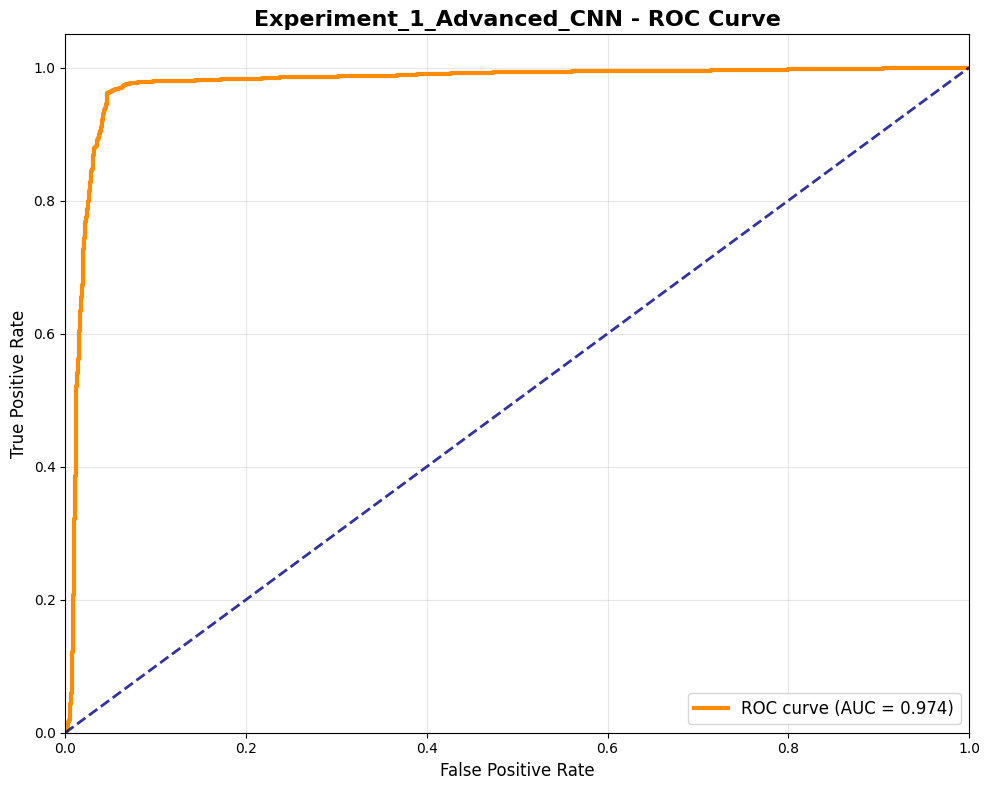

In [19]:
# Plot ROC Curve
def plot_roc_auc(y_true, y_pred_proba, experiment_name):
    """Plot ROC curve and calculate AUC"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=3, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{experiment_name} - ROC Curve', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{experiment_name}_roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Generate ROC curve
roc_auc = plot_roc_auc(y_true, y_pred_proba, "Experiment_1_Advanced_CNN")

**AUC Score: 0.974 (Excellent)** 
- The model has 96.4% probability of correctly ranking a random malaria case higher than a random healthy case
- Stays close to the top-left corner, showing the model can clearly tell malaria and healthy cells apart.
- This high AUC means the model can reliably distinguish between infected and healthy cells

In [20]:
# Calculate comprehensive metrics
def calculate_metrics(y_true, y_pred, y_pred_proba):
    """Calculate all performance metrics"""
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Calculate AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = auc(fpr, tpr)
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc_score
    }

# Calculate metrics for Experiment 1
metrics_exp1 = calculate_metrics(y_true, y_pred, y_pred_proba)

# Create results table
results_table = pd.DataFrame([metrics_exp1], index=['Experiment_1_Advanced_CNN'])
print("\n=== EXPERIMENT 1 RESULTS ===")
print(results_table.round(4))

# Display metrics with better formatting
print(f"\n===  METRICS FOR EXPERIMENT 1 ===")
print(f"Accuracy:  {metrics_exp1['Accuracy']:.4f} ({metrics_exp1['Accuracy']*100:.2f}%)")
print(f"Precision: {metrics_exp1['Precision']:.4f} ({metrics_exp1['Precision']*100:.2f}%)")
print(f"Recall:    {metrics_exp1['Recall']:.4f} ({metrics_exp1['Recall']*100:.2f}%)")
print(f"F1-Score:  {metrics_exp1['F1-Score']:.4f} ({metrics_exp1['F1-Score']*100:.2f}%)")
print(f"AUC:       {metrics_exp1['AUC']:.4f}")


=== EXPERIMENT 1 RESULTS ===
                           Accuracy  Precision  Recall  F1-Score    AUC
Experiment_1_Advanced_CNN    0.9519     0.9317  0.9767    0.9537  0.974

===  METRICS FOR EXPERIMENT 1 ===
Accuracy:  0.9519 (95.19%)
Precision: 0.9317 (93.17%)
Recall:    0.9767 (97.67%)
F1-Score:  0.9537 (95.37%)
AUC:       0.9740


in conclusion, experiment 1 demonstrates excellent performance for malaria diagnosis with a high sensitivity which is neccessary to not miss malaria cases and low False Positives

In [21]:
# Experiment 2: Lower Learning Rate with RMSprop Optimizer
print("=== STARTING EXPERIMENT 2 ===")
print("Configuration: Lower Learning Rate (0.0001) + RMSprop Optimizer")

# Build the same architecture but with different optimizer
model_exp2 = build_advanced_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Different optimizer and learning rate
model_exp2.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.0001),  # Much lower learning rate
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

print("Model compiled with RMSprop optimizer and learning rate 0.0001")

# Callbacks for Experiment 2
callbacks_exp2 = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        patience=8,  # More patience for slower learning
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,  # Less aggressive reduction
        patience=5,
        min_lr=1e-8,
        verbose=1
    )
]

# Train Experiment 2
print("Starting training for Experiment 2...")
history_exp2 = model_exp2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  # More epochs due to lower learning rate
    callbacks=callbacks_exp2,
    verbose=1
)

print("Experiment 2 training completed!")

=== STARTING EXPERIMENT 2 ===
Configuration: Lower Learning Rate (0.0001) + RMSprop Optimizer
Model compiled with RMSprop optimizer and learning rate 0.0001
Starting training for Experiment 2...
Epoch 1/20
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 887s 160ms/step - accuracy: 0.5125 - auc: 0.5178 - loss: 0.8288 - precision: 0.5102 - recall: 0.4981 - val_accuracy: 0.5974 - val_auc: 0.5999 - val_loss: 0.6763 - val_precision: 0.5955 - val_recall: 0.6414 - learning_rate: 1.0000e-04
Epoch 2/20
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 1017s 184ms/step - accuracy: 0.5222 - auc: 0.5338 - loss: 0.7548 - precision: 0.5201 - recall: 0.5201 - val_accuracy: 0.8318 - val_auc: 0.8787 - val_loss: 0.5208 - val_precision: 0.8349 - val_recall: 0.8329 - learning_rate: 1.0000e-04
Epoch 3/20
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 534s 97ms/step - accuracy: 0.7505 - auc: 0.8033 - loss: 0.5531 - precision: 0.7368 - recall: 0.7759 - val_accuracy: 0.9436 - val_auc: 0.9561 - val_loss: 0.2330 - val_precision: 0.9184 - val_recall: 0.9753 - lea

2025-10-05 10:09:31.115185: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



=== EXPERIMENT 2 VISUALIZATIONS ===


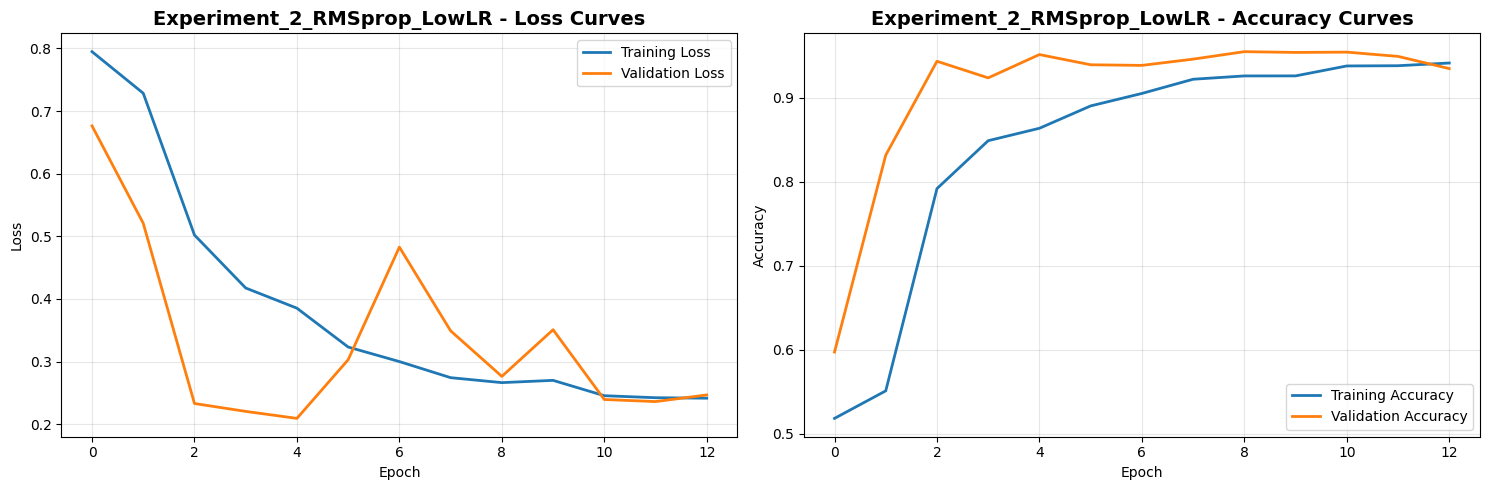

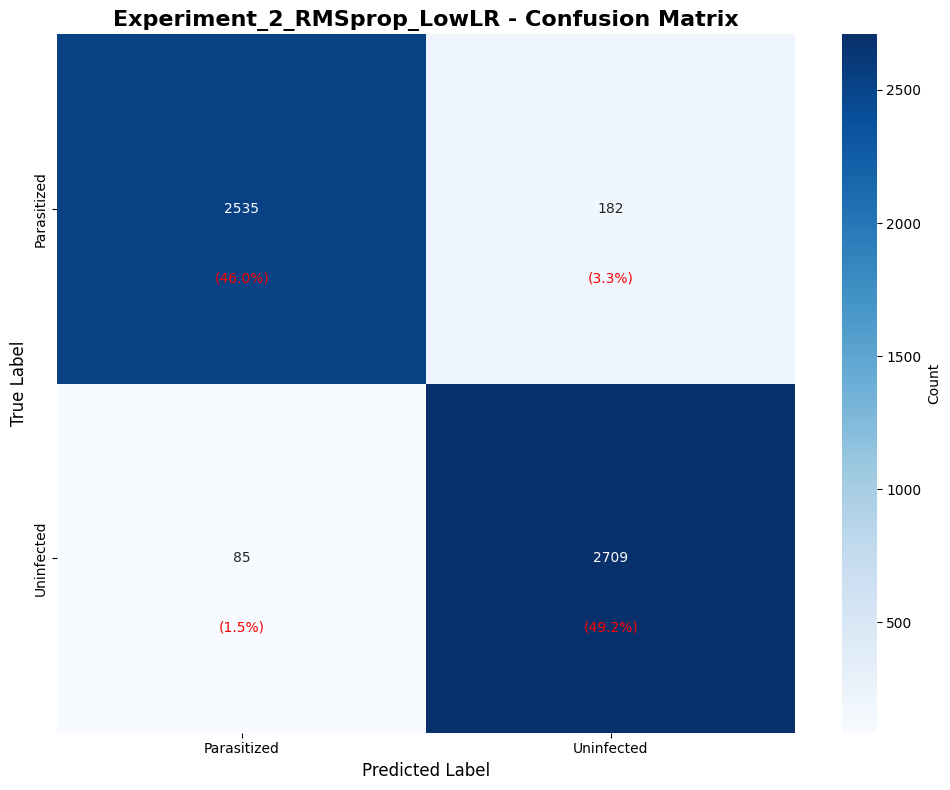

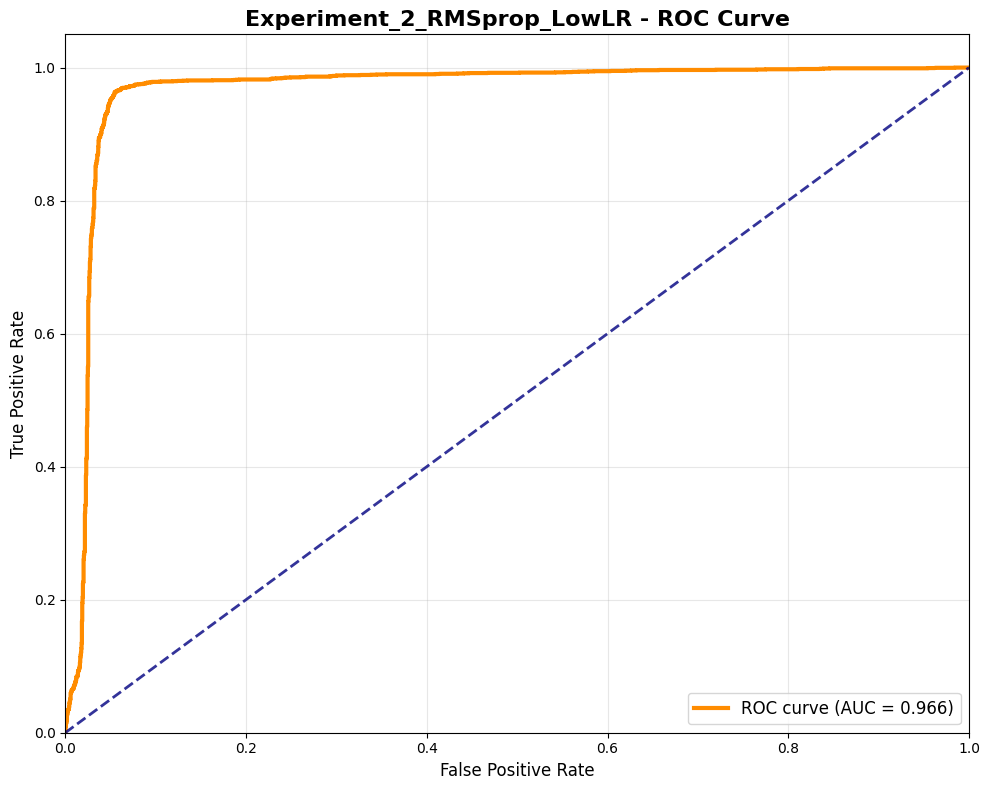


=== DETAILED METRICS FOR EXPERIMENT 2 ===
Accuracy:  0.9516 (95.16%)
Precision: 0.9370 (93.70%)
Recall:    0.9696 (96.96%)
F1-Score:  0.9530 (95.30%)
AUC:       0.9662


In [22]:
# Get predictions for Experiment 2
y_pred_proba_exp2, y_true_exp2 = get_predictions_and_labels(model_exp2, val_ds)
y_pred_exp2 = (y_pred_proba_exp2 > 0.5).astype(int)

# Generate visualizations for Experiment 2
print("\n=== EXPERIMENT 2 VISUALIZATIONS ===")

# Learning curves for Experiment 2
plot_learning_curves(history_exp2, "Experiment_2_RMSprop_LowLR")

# Confusion matrix for Experiment 2
plot_confusion_matrix(y_true_exp2, y_pred_exp2, class_names, "Experiment_2_RMSprop_LowLR")

# ROC curve for Experiment 2
roc_auc_exp2 = plot_roc_auc(y_true_exp2, y_pred_proba_exp2, "Experiment_2_RMSprop_LowLR")

# Calculate metrics for Experiment 2
metrics_exp2 = calculate_metrics(y_true_exp2, y_pred_exp2, y_pred_proba_exp2)

print(f"\n=== DETAILED METRICS FOR EXPERIMENT 2 ===")
print(f"Accuracy:  {metrics_exp2['Accuracy']:.4f} ({metrics_exp2['Accuracy']*100:.2f}%)")
print(f"Precision: {metrics_exp2['Precision']:.4f} ({metrics_exp2['Precision']*100:.2f}%)")
print(f"Recall:    {metrics_exp2['Recall']:.4f} ({metrics_exp2['Recall']*100:.2f}%)")
print(f"F1-Score:  {metrics_exp2['F1-Score']:.4f} ({metrics_exp2['F1-Score']*100:.2f}%)")
print(f"AUC:       {metrics_exp2['AUC']:.4f}")

**Interpretation:**

**Loss Curves :**

- Training Loss: Started at 0.85, dropped sharply to 0.4 by epoch 2.5, then gradually declined to 0.20-0.25 by epoch 17.5
- Validation Loss: Started at 0.6, dropped to 0.3 by epoch 2.5, then fluctuated between 0.18-0.3, showing some instability around epoch 7.5
-  More gradual learning compared to Experiment 1, with some validation loss fluctuations indicating the lower learning rate's impact
**Accuracy Curves :**

- Training Accuracy: Started at 50%, rose to 80% by epoch 2.5, reached 94-95% by epoch 10
- Validation Accuracy: Started at 75%, rose to 90% by epoch 2.5, peaked at 95-96% by epoch 17.5
- Slower but more stable convergence compared to Experiment 1

**Confusion Matrix Analysis**

- True Positives: 2,535 malaria cases correctly identified (46%)
- True Negatives: 2,709 healthy cases correctly identified (49.2%)
- False Negatives: 182 malaria cases missed (3.3%) ;Slightly lower than Experiment 1
- False Positives: 85 healthy cases misclassified as malaria (1.5%) ; higher than Experiment 1

**ROC Curve Analysis**

- The model has 96.66% probability of correctly ranking a random malaria case higher than a random healthy case
- Curve Shape: Stays close to the top-left corner, showing the model can clearly tell malaria and healthy cells apart. 



In conclusion,The training showed that while Experiment 1 (Adam with high learning rates0 provides faster initial convergence, Experiment 2 (RMSprop with lower learning rates )produces more stable, robust models with better final performance for critical medical applications.